# **ML4NLP1**- **Assignment 2**

## Part 1- CBOW2

Importing the libraries and the dataset

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from tqdm import trange


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch import autograd

import re
import string
exclude = string.punctuation

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

from textblob import TextBlob
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

from nltk import word_tokenize, pos_tag
from collections import Counter

torch.manual_seed(1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
%%javascript

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#toolbar-add-code").click() 
}setInterval(ClickConnect,1200)

<IPython.core.display.Javascript object>

In [3]:
df_hotel_reviews = pd.read_csv('tripadvisor_hotel_reviews.csv')
obj_scifi = open("scifi.txt","r")
df_scifi = obj_scifi.read()

Creating Preprocessing and Word Embedding Classes

In [4]:
# data preprocessing class
class Preprocessing:

  # lowercasing
  def convert_lowercase(self,text):
      text = text.lower()
      return text

  # removing html tags
  def remove_html_tags(self,text):
      re_html = re.compile('<.*?>')
      return re_html.sub(r'', text)

  # removing URLS
  def remove_url(self,text):
      re_url = re.compile('https?://\S+|www\.\S+')
      return re_url.sub('', text)

  # removing punctuations
  def remove_punc(self,text):
      return text.translate(str.maketrans('', '', exclude))

  # removing special characters
  def remove_special(self,text):
      x=''
      for i in text:
          if i.isalnum():
              x=x+i
          else:
              x=x+' '
      return x

  # removing digits
  def remove_digits(self,text):
      filtered_string = ''.join((x for x in text if not x.isdigit()))
      return filtered_string

  #removing textblob
  def textblob(self,text):
    textblob_ = TextBlob(text)
    return textblob_

  # removing stop words
  def remove_stopwords(self,text):
      new_text = []
      for word in text.split():
          if word in stopwords_english:
              continue
          else:
              new_text.append(word)

      return ' '.join(new_text)

  def preprocess(self,text):
    text = self.convert_lowercase(text)
    text = self.remove_html_tags(text)
    text = self.remove_url(text)
    text = self.remove_digits(text)
    text = self.remove_punc(text)
    text = self.remove_special(text)
    text = self.textblob(text)
    text = self.remove_stopwords(text)

    return text

In [5]:
# word embedding class
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

#implementation class
class implement_CBOW():

  def __init__(self, vocab_size, embedding_dim, context_size):
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.context_size = context_size

  def make_context_vector(self, context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

  def plot_losses(self, losses):
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss vs epoch")
    plt.show()

  def implement_CBOW_model(self, data_full, epochs, word_to_ix):
    losses = []
    loss_function = nn.NLLLoss()

    # initializing CUDA adn adding model to device
    model = CBOW(self.vocab_size, self.embedding_dim, self.context_size)
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    
    # also experimented with lr=0.001, 0.0001, 0.005, 0.05, 0.002 and 'Adam' optimizer
    optimizer = optim.SGD(model.parameters(), lr=0.01) 
    
    for epoch in range(epochs):
      total_loss = 0  
      data_for_batch = data_full
      # using dataloader to split data into batch sizes of 10000 
      for i, data in enumerate(tqdm(DataLoader(data_for_batch, batch_size=10000, shuffle=False, num_workers=2, pin_memory=True))):
        data_emb = []

        for j in range(2, len(data) - 2):
          context = [data[j - 2], data[j - 1],
                    data[j + 1], data[j + 2]]
          target = data[j]
          data_emb.append((context,target))

        for context, target in data_emb:
          # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
          # into integer indices and wrap them in tensors)
          context_idxs = self.make_context_vector(context, word_to_ix).cuda()

          # Step 2. Recall that torch *accumulates* gradients. Before passing in a
          # new instance, you need to zero out the gradients from the old
          # instance
          model.zero_grad(set_to_none=True)
          
          # Step 3. Run the forward pass, getting log probabilities over next
          # words
          log_probs = model(context_idxs).cuda()

          # Step 4. Compute your loss function. (Again, Torch wants the target
          # word wrapped in a tensor)
          loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long).cuda())

        # Step 5. Do the backward pass and update the gradient
        # updating weights for each batch
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()

      #printing loss for each epoch
      print(f'Epoch [{epoch}/{epochs}], loss: {loss:.4f}]')
      losses.append(total_loss)
    
    self.plot_losses(losses)

    return model

CBOW2 on the Hotel Reviews

100%|██████████| 202/202 [14:39<00:00,  4.35s/it]


Epoch [0/12], loss: 11.3196]


100%|██████████| 202/202 [14:24<00:00,  4.28s/it]


Epoch [1/12], loss: 10.9006]


100%|██████████| 202/202 [14:26<00:00,  4.29s/it]


Epoch [2/12], loss: 10.4924]


100%|██████████| 202/202 [14:19<00:00,  4.26s/it]


Epoch [3/12], loss: 9.9826]


100%|██████████| 202/202 [14:23<00:00,  4.27s/it]


Epoch [4/12], loss: 9.3190]


100%|██████████| 202/202 [14:20<00:00,  4.26s/it]


Epoch [5/12], loss: 8.4152]


100%|██████████| 202/202 [14:27<00:00,  4.29s/it]


Epoch [6/12], loss: 7.1246]


100%|██████████| 202/202 [14:25<00:00,  4.29s/it]


Epoch [7/12], loss: 5.3177]


100%|██████████| 202/202 [14:25<00:00,  4.28s/it]


Epoch [8/12], loss: 3.0615]


100%|██████████| 202/202 [14:24<00:00,  4.28s/it]


Epoch [9/12], loss: 0.8500]


100%|██████████| 202/202 [14:25<00:00,  4.29s/it]


Epoch [10/12], loss: 0.1790]


100%|██████████| 202/202 [14:26<00:00,  4.29s/it]


Epoch [11/12], loss: 0.1001]


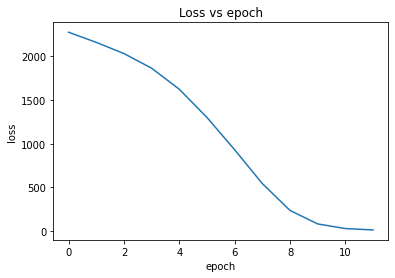

In [6]:
hotel_reviews = " ".join(df_hotel_reviews["Review"])
hotel_reviews = Preprocessing().preprocess(hotel_reviews)

hotel_reviews_raw = hotel_reviews.split()

vocab_reviews = set(hotel_reviews_raw)
vocab_size_reviews = len(vocab_reviews)

word_to_ix_reviews = {word: i for i, word in enumerate(vocab_reviews)}
ix_to_word_reviews = {i:word for i, word in enumerate(vocab_reviews)}

EMBEDDING_DIM = 50
CONTEXT_SIZE = 4

cbow_reviews = implement_CBOW(vocab_size=vocab_size_reviews, 
                      embedding_dim=EMBEDDING_DIM, context_size= CONTEXT_SIZE)
model_reviews = cbow_reviews.implement_CBOW_model(hotel_reviews_raw, epochs=12, word_to_ix=word_to_ix_reviews)

CBOW2 on Sci-fi

100%|██████████| 789/789 [1:41:08<00:00,  7.69s/it]


Epoch [0/2], loss: 12.5380]


100%|██████████| 789/789 [1:40:08<00:00,  7.62s/it]


Epoch [1/2], loss: 11.9435]


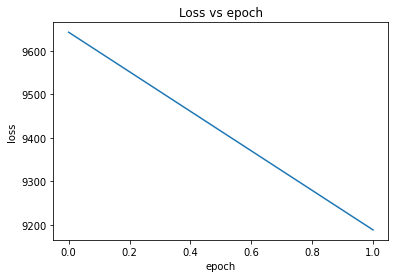

In [ ]:
scifi_text = Preprocessing().preprocess(df_scifi)

scifi_text_raw = scifi_text.split()

vocab_scifi = set(scifi_text_raw)
vocab_size_scifi = len(vocab_scifi)

word_to_ix_scifi = {word: i for i, word in enumerate(vocab_scifi)}
ix_to_word_scifi = {i: word for i, word in enumerate(vocab_scifi)}

EMBEDDING_DIM = 50
CONTEXT_SIZE = 4

cbow_scifi = implement_CBOW(vocab_size=vocab_size_scifi, 
                      embedding_dim=EMBEDDING_DIM, context_size= CONTEXT_SIZE)
model_scifi = cbow_scifi.implement_CBOW_model(scifi_text_raw, epochs=2, word_to_ix=word_to_ix_scifi)

### Part 2

In [7]:
# function for finding the 3 nouns/verbs/adjectives
def get_three_words(data,tag):
  raw_data = data.split()
  word_counter = Counter(raw_data)
  pos_tag_counter = list(set([(word, word_counter[word], pos) for word,pos in pos_tag(word_tokenize(data)) if pos.startswith(tag)]))
  pos_tag_counter.sort(key= lambda x: x[1])
  # returning most frequent, least freaques and a middle word
  return (pos_tag_counter[0][0],pos_tag_counter[-1][0],pos_tag_counter[int(len(pos_tag_counter)/2)][0])


In [8]:
# adding 9 words for Hotel Reviews dataset to a list and printing them
hotel_review_whole = []
for tag in ["N","V","J"]:
  words = get_three_words(hotel_reviews, tag)
  hotel_review_whole.append(words)

print("Hotel review words-- Nouns: {}, Verbs: {}, Adjectives: {}".format(hotel_review_whole[0],hotel_review_whole[1],hotel_review_whole[2]))


Hotel review words-- Nouns: ('scuf', 'hotel', 'taqueria'), Verbs: ('sojourned', 'hotel', 'barge'), Adjectives: ('wallsized', 'hotel', 'warrent')


In [ ]:
# adding 9 words for Sci-fi dataset to a list and printing them
scifi_whole = []
for tag in ["N","V","J"]:
  words = get_three_words(scifi_text, tag)
  scifi_whole.append(words)

print("Scifi words-- Nouns: {}, Verbs: {}, Adjectives: {}".format(scifi_whole[0],scifi_whole[1],scifi_whole[2]))

Scifi words-- Nouns: ('twinkie', 'one', 'ausfaller'), Verbs: ('sheering', 'said', 'horseback'), Adjectives: ('skulltight', 'one', 'adisplacement')


In [9]:
#function for obtaining the closest words
def get_closest_word(word, model, vocab, word_to_ix, ix_to_word, topn=5):
    word_distance = []
    emb = model.embeddings
    pdist = nn.PairwiseDistance()
    i = word_to_ix[word]
    lookup_tensor_i = torch.tensor([i], dtype=torch.long).cuda()
    v_i = emb(lookup_tensor_i)
    for j in range(len(vocab)):
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long).cuda()
            v_j = emb(lookup_tensor_j)
            word_distance.append((ix_to_word[j], float(pdist(v_i, v_j))))
    word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]


In [ ]:
scifi_words = [word for item in scifi_whole for word in item]

# printing 5 closest words in Sci-fi dataset 
print("--------- Scifi Embedding ----------")
for i in scifi_words:
  prediction = get_closest_word(i, model_scifi, vocab_scifi, word_to_ix_scifi, ix_to_word_scifi, topn = 5)
  print('Word: ', i, '   Predictions: ', prediction)

--------- Scifi Embedding ----------
Word:  twinkie    Predictions:  [('balewa', 6.9823689460754395), ('gustibles', 7.046282768249512), ('booklength', 7.092227935791016), ('modernity', 7.207363605499268), ('aong', 7.2464165687561035)]
Word:  one    Predictions:  [('dratted', 5.872995376586914), ('unconsidered', 5.9480671882629395), ('prononacementa', 5.9675798416137695), ('newbuilt', 6.05281925201416), ('larkas', 6.064686298370361)]
Word:  ausfaller    Predictions:  [('archelon', 5.864109516143799), ('soberhogen', 6.000680446624756), ('transformers', 6.294220924377441), ('preiliminiaiy', 6.2953572273254395), ('slopehead', 6.347241401672363)]
Word:  sheering    Predictions:  [('greetingcard', 6.355785846710205), ('barehanded', 6.671032905578613), ('vfgilant', 6.902981758117676), ('conkin', 6.91696310043335), ('platypusses', 6.983938694000244)]
Word:  said    Predictions:  [('curvebottomed', 5.108492374420166), ('lastcited', 5.159820556640625), ('merchantcaptains', 5.293136119842529), ('

In [10]:
review_words = [word for item in hotel_review_whole for word in item]

# printing 5 closest words in Hotel Reviews dataset 
print("--------- Hotel Review Embedding ----------")
for i in review_words:
  prediction = get_closest_word(i, model_reviews, vocab_reviews, word_to_ix_reviews, ix_to_word_reviews, topn = 5)
  print('Word: ', i, '   Predictions: ', prediction)

--------- Hotel Review Embedding ----------
Word:  scuf    Predictions:  [('pankcakes', 6.93496561050415), ('market', 7.012598037719727), ('hinti', 7.114603519439697), ('otherhours', 7.209336757659912), ('recommenedcasino', 7.232057094573975)]
Word:  hotel    Predictions:  [('replacedthe', 6.951484203338623), ('bridgehighly', 6.951977252960205), ('switzerland', 7.061190128326416), ('supercentral', 7.067756652832031), ('belong', 7.1965651512146)]
Word:  taqueria    Predictions:  [('sented', 5.928685188293457), ('trael', 6.3823347091674805), ('unmatchabled', 6.385087966918945), ('helpfulthank', 6.49245548248291), ('bottomline', 6.498477458953857)]
Word:  sojourned    Predictions:  [('kewl', 6.4075927734375), ('atmosphereexcellent', 6.623318195343018), ('banki', 6.699078559875488), ('tripsit', 6.736910343170166), ('conducted', 6.760068416595459)]
Word:  hotel    Predictions:  [('replacedthe', 6.951484203338623), ('bridgehighly', 6.951977252960205), ('switzerland', 7.061190128326416), ('su

Common Word Embeddings

In [ ]:
# finding the two common words amongst scifi text and hotel review text
two_common_words = list(set(hotel_reviews_raw).intersection(scifi_text_raw))[:2]
two_common_words

['frequented', 'gothic']

In [12]:
print("--------- Hotel Review Embedding ----------")
for i in two_common_words:
  prediction = get_closest_word(i, model_reviews, vocab_reviews, word_to_ix_reviews, ix_to_word_reviews, topn = 5)
  print('Word: ', i, '   Predictions: ', prediction)

--------- Hotel Review Embedding ----------
Word:  frequented    Predictions:  [('vacancy', 6.7429046630859375), ('packetscreamer', 6.935954570770264), ('familychildren', 6.99105167388916), ('mealsthe', 7.017496109008789), ('planeçé', 7.063321113586426)]
Word:  gothic    Predictions:  [('queenbed', 6.158846855163574), ('materials', 6.335575580596924), ('baccanales', 6.389595985412598), ('mustdo', 6.390081405639648), ('eminating', 6.451117992401123)]


In [ ]:
print("--------- Scifi Embedding ----------")
for i in two_common_words:
  prediction = get_closest_word(i, model_scifi, vocab_scifi, word_to_ix_scifi, ix_to_word_scifi, topn = 5)
  print('Word: ', i, '   Predictions: ', prediction)

--------- Scifi Embedding ----------
Word:  frequented    Predictions:  [('iridescence', 5.648218154907227), ('gore', 5.666444778442383), ('circustent', 6.112143516540527), ('geries', 6.121190071105957), ('mismatching', 6.140778541564941)]
Word:  gothic    Predictions:  [('brio', 6.6173601150512695), ('moskowitz', 6.707886219024658), ('benchlike', 6.709280490875244), ('powerful', 6.786182880401611), ('panding', 6.801762580871582)]
